## Evaluation of New York and Toronto by venues


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

################################################################

# instantiating the libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from pandas import DataFrame
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means for clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

!pip install geocoder
import geocoder


!pip install lxml

import matplotlib
import matplotlib.pyplot as plt



print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

## 1. Explore NYC Dataset


Utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [2]:
CLIENT_ID = 'NUVVRJQRBCVLGGQ4POH05J5SPFARUGA30UDP0PN45ABPD13P' # your Foursquare ID
CLIENT_SECRET = 'XDPHQLSL5S34IKSICQFRHMNBS2TTG3TCBOENULPUZW3DXRZL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NUVVRJQRBCVLGGQ4POH05J5SPFARUGA30UDP0PN45ABPD13P
CLIENT_SECRET:XDPHQLSL5S34IKSICQFRHMNBS2TTG3TCBOENULPUZW3DXRZL


#### Use geopy library to get the latitude and longitude values of New York City.

In [3]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


First, let's create the GET request URL. Name your URL **url**.


In [4]:
# type your answer here
LIMIT = 100 # limit of number of venues
radius = 500 # # radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude1, 
    longitude1, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=NUVVRJQRBCVLGGQ4POH05J5SPFARUGA30UDP0PN45ABPD13P&client_secret=XDPHQLSL5S34IKSICQFRHMNBS2TTG3TCBOENULPUZW3DXRZL&v=20180605&ll=40.7127281,-74.0060152&radius=500&limit=100'

Send the GET request and examine the results


In [5]:
results = requests.get(url).json()
#results

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [7]:
venues = results['response']['groups'][0]['items']
#venues = results['response']['venues'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
#filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row'
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng,postalCode
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802,10038
1,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702,10038
2,City Hall Park,Park,40.712359,-74.007493,10038
3,Gibney Dance Center Downtown,Dance Studio,40.713923,-74.005661,10007
4,Alba Dry Cleaner & Tailor,Laundry Service,40.711434,-74.006272,10038


NA values must be removed. The assumption is that all venues must have a valid postal zip code

In [8]:
#purge any venues with no valid postalCode
nearby_venues.dropna(subset=['postalCode'], inplace=True)

Determine the number of the venues returned by FourSquare API

In [9]:
#print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
print('{} venues were returned by Foursquare.'.format(nearby_venues['categories'].count()))

100 venues were returned by Foursquare.


In [10]:
print('There are {} uniques categories.'.format(len(nearby_venues['categories'].unique())))

There are 64 uniques categories.


<a id='item2'></a>


Let's check how many venues were returned for each neighborhood


In [11]:
nearby_venues['categories'].value_counts().head().nlargest(5)

Coffee Shop           5
Hotel                 4
Italian Restaurant    3
Falafel Restaurant    3
Spa                   3
Name: categories, dtype: int64

#### Number of unique venue categories curated from the returned venues


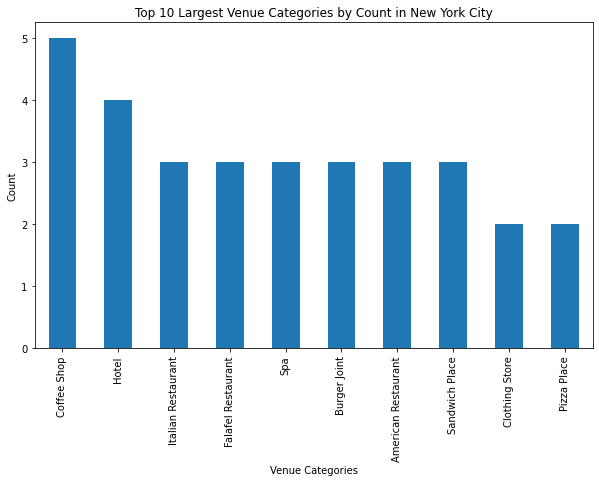

In [12]:
s = nearby_venues['categories'].value_counts().head(10).nlargest(10)

# step 2: plot data
s.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue Categories') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Top 10 Largest Venue Categories by Count in New York City') # add title to the plot

plt.show()

### Create a map of New York City with venues superimposed on top

In [13]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude1, longitude1], zoom_start=14)

# add markers to map
for nm, catg, lat, lng in zip(nearby_venues['name'], nearby_venues['categories'], nearby_venues['lat'], nearby_venues['lng']):
    label = '{}, {}'.format(nm, catg)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<a id='item3'></a>


## 2. Analyze NYC zip codes


In [14]:
# one hot encoding
nyc_onehot = pd.get_dummies(nearby_venues[['categories']], prefix="", prefix_sep="")
#nyc_onehot = pd.get_dummies(nearby_venues[['categories']])

# add postal code column back to dataframe
nyc_onehot['postalCode'] = nearby_venues['postalCode'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,postalCode,American Restaurant,Antique Shop,Asian Restaurant,Baby Store,Bagel Shop,Bakery,Bookstore,Boxing Gym,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Café,Cajun / Creole Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Greek Restaurant,Gym,Gym / Fitness Center,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Laundry Service,Medical Center,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Nail Salon,Park,Pilates Studio,Pizza Place,Plaza,Poke Place,Restaurant,Salad Place,Sandwich Place,Shopping Mall,Soup Place,Spa,Strip Club,Sushi Restaurant,Taco Place,Vegetarian / Vegan Restaurant,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.


In [15]:
nyc_onehot.shape

(100, 65)

In [16]:
nyc_grouped = nyc_onehot.groupby('postalCode').mean().reset_index()
nyc_grouped

,postalCode,American Restaurant,Antique Shop,Asian Restaurant,Baby Store,Bagel Shop,Bakery,Bookstore,Boxing Gym,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Café,Cajun / Creole Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Greek Restaurant,Gym,Gym / Fitness Center,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Laundry Service,Medical Center,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Nail Salon,Park,Pilates Studio,Pizza Place,Plaza,Poke Place,Restaurant,Salad Place,Sandwich Place,Shopping Mall,Soup Place,Spa,Strip Club,Sushi Restaurant,Taco Place,Vegetarian / Vegan Restaurant,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10007,0.023810,0.02381,0.000000,0.02381,0.02381,0.023810,0.02381,0.02381,0.00000,0.02381,0.0,0.02381,0.00000,0.02381,0.02381,0.023810,0.047619,0.00000,0.00000,0.00000,0.02381,0.00000,0.02381,0.02381,0.023810,0.00000,0.02381,0.00000,0.02381,0.00000,0.02381,0.023810,0.023810,0.02381,0.047619,0.02381,0.00000,0.02381,0.02381,0.00000,0.000000,0.00000,0.000000,0.02381,0.00000,0.000000,0.000000,0.00000,0.02381,0.00000,0.000000,0.02381,0.02381,0.02381,0.00000,0.000000,0.02381,0.000000,0.02381,0.02381,0.047619,0.02381,0.02381,0.02381
1,10013,0.066667,0.00000,0.066667,0.00000,0.00000,0.066667,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.066667,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.066667,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.066667,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.066667,0.00000,0.066667,0.00000,0.00000,0.066667,0.066667,0.00000,0.00000,0.00000,0.066667,0.00000,0.00000,0.00000,0.00000,0.133333,0.00000,0.133333,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000
2,10038,0.024390,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.02439,0.02439,0.0,0.04878,0.02439,0.00000,0.02439,0.000000,0.073171,0.02439,0.02439,0.02439,0.00000,0.02439,0.00000,0.00000,0.024390,0.02439,0.02439,0.02439,0.00000,0.02439,0.02439,0.000000,0.073171,0.02439,0.000000,0.04878,0.02439,0.00000,0.00000,0.02439,0.000000,0.02439,0.000000,0.00000,0.02439,0.024390,0.000000,0.04878,0.00000,0.02439,0.024390,0.00000,0.04878,0.00000,0.02439,0.024390,0.00000,0.000000,0.02439,0.00000,0.000000,0.00000,0.00000,0.02439
3,10279,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.5,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.50000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000


In [17]:
nyc_grouped.shape

(4, 65)

####  Printing each zip code along with the top 5 most common venues

In [18]:
num_top_venues = 5

for hood in nyc_grouped['postalCode']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['postalCode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----10007----
                 venue  freq
0            Wine Shop  0.05
1    Indian Restaurant  0.05
2          Coffee Shop  0.05
3  American Restaurant  0.02
4    Korean Restaurant  0.02


----10013----
                  venue  freq
0                   Spa  0.13
1      Sushi Restaurant  0.13
2   American Restaurant  0.07
3  Gym / Fitness Center  0.07
4        Medical Center  0.07


----10038----
                venue  freq
0               Hotel  0.07
1         Coffee Shop  0.07
2      Sandwich Place  0.05
3  Italian Restaurant  0.05
4         Pizza Place  0.05


----10279----
                       venue  freq
0                      Plaza   0.5
1                   Building   0.5
2        American Restaurant   0.0
3         Italian Restaurant   0.0
4  Japanese Curry Restaurant   0.0




Function to sort the venues in descending order.


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each zip code.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venue categories
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postal_code_venues_sorted = pd.DataFrame(columns=columns)
postal_code_venues_sorted['postalCode'] = nyc_grouped['postalCode']

for ind in np.arange(nyc_grouped.shape[0]):
    postal_code_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

postal_code_venues_sorted.head()

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10007,Indian Restaurant,Coffee Shop,Wine Shop,Hotel Bar,Hotel,Women's Store,Gym,Furniture / Home Store,French Restaurant,Falafel Restaurant
1,10013,Sushi Restaurant,Spa,Gym / Fitness Center,Restaurant,Asian Restaurant,Bakery,Cocktail Bar,Falafel Restaurant,Medical Center,Molecular Gastronomy Restaurant
2,10038,Hotel,Coffee Shop,Italian Restaurant,Burger Joint,Pizza Place,Sandwich Place,Yoga Studio,Fast Food Restaurant,Hotel Bar,Gym
3,10279,Plaza,Building,Yoga Studio,Discount Store,Comic Shop,Coworking Space,Cuban Restaurant,Dance Studio,Donut Shop,Cocktail Bar


<a id='item4'></a>


### Cluster venues

Run _k_-means to cluster the zip codes into  clusters.

In [21]:
# set number of clusters
kclusters = 4

nyc_grouped_clustering = nyc_grouped.drop('postalCode', 1)

#nyc_grouped_clustering.head()

#nearby_venues.sort_values(by=['categories'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nearby_venues)


# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 3, 1], dtype=int32)

In [22]:
#del neighborhoods_venues_sorted

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each zip code.

In [23]:
# add clustering labels
postal_code_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nearby_venues

# merge nyc_grouped with nyc_data to add latitude/longitude for each zip code
nyc_merged = nyc_merged.join(postal_code_venues_sorted.set_index('postalCode'), on='postalCode')

nyc_merged.head() # check the last columns!

,name,categories,lat,lng,postalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802,10038,3,Hotel,Coffee Shop,Italian Restaurant,Burger Joint,Pizza Place,Sandwich Place,Yoga Studio,Fast Food Restaurant,Hotel Bar,Gym
1,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702,10038,3,Hotel,Coffee Shop,Italian Restaurant,Burger Joint,Pizza Place,Sandwich Place,Yoga Studio,Fast Food Restaurant,Hotel Bar,Gym
2,City Hall Park,Park,40.712359,-74.007493,10038,3,Hotel,Coffee Shop,Italian Restaurant,Burger Joint,Pizza Place,Sandwich Place,Yoga Studio,Fast Food Restaurant,Hotel Bar,Gym
3,Gibney Dance Center Downtown,Dance Studio,40.713923,-74.005661,10007,0,Indian Restaurant,Coffee Shop,Wine Shop,Hotel Bar,Hotel,Women's Store,Gym,Furniture / Home Store,French Restaurant,Falafel Restaurant
4,Alba Dry Cleaner & Tailor,Laundry Service,40.711434,-74.006272,10038,3,Hotel,Coffee Shop,Italian Restaurant,Burger Joint,Pizza Place,Sandwich Place,Yoga Studio,Fast Food Restaurant,Hotel Bar,Gym


Finally, let's visualize the resulting clusters


In [24]:
# create map
map_clusters = folium.Map(location=[latitude1, longitude1], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['lat'], nyc_merged['lng'], nyc_merged['postalCode'], nyc_merged['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(cluster) + ': ' + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


### Examine Clusters by Most Common venue


#### Cluster 1

In [25]:
x1=nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
x1.drop(columns=['categories'], inplace = True)
x1['1st Most Common Venue'].value_counts().idxmax()
#x1.value_counts().head(10).nlargest(1)
#x1

'Indian Restaurant'

#### Cluster 2


In [26]:
x2=nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
x2.drop(columns=['categories'], inplace = True)
x2['1st Most Common Venue'].value_counts().idxmax()
#x2['1st Most Common Venue'].value_counts()
#x2.value_counts().head(10).nlargest(1)

'Plaza'

#### Cluster 3


In [27]:
x3=nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
x3.drop(columns=['categories'], inplace = True)
x3['1st Most Common Venue'].value_counts().idxmax()
#x3['1st Most Common Venue'].value_counts()

'Sushi Restaurant'

#### Cluster 4


In [28]:
x4=nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
x4.drop(columns=['categories'], inplace = True)
x4['1st Most Common Venue'].value_counts().idxmax()
#x4['1st Most Common Venue'].value_counts()

'Hotel'

#### Cluster 5


In [29]:
#x5=nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
#x5.drop(columns=['categories'], inplace = True)
#x5['1st Most Common Venue'].value_counts().idxmax()
#x5['1st Most Common Venue'].value_counts().head().nlargest(5)

In [30]:
#x6=nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
#x6.drop(columns=['categories'], inplace = True)
#x6['1st Most Common Venue'].value_counts().idxmax()
#x6['1st Most Common Venue'].value_counts().head().nlargest(5)

In [31]:
#x7=nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
#x7.drop(columns=['categories'], inplace = True)
#x7['1st Most Common Venue'].value_counts().idxmax()
#x7['1st Most Common Venue'].value_counts().head().nlargest(5)

In [32]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['lat'], nyc_merged['lng'], nyc_merged['postalCode'], nyc_merged['Cluster Labels']):
    xtemp=nyc_merged.loc[nyc_merged['Cluster Labels'] == cluster, nyc_merged.columns[[1] + list(range(4, nyc_merged.shape[1]))]]
    new_cluster=xtemp['1st Most Common Venue'].value_counts().idxmax()
    label = folium.Popup('Cluster ' + str(cluster) + ': ' + str(new_cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# ================ End of NYC analysis ================

## 3. Explore TOR Dataset

#### Use geopy library to get the latitude and longitude values of Toronto.

In [33]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="tor_explorer")
location2 = geolocator.geocode(address)
latitude2 = location2.latitude
longitude2 = location2.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [34]:
# type your answer here
LIMIT = 100 # limit of number of venues
radius = 500 # # radius
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude2, 
    longitude2, 
    radius, 
    LIMIT)
url2 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=NUVVRJQRBCVLGGQ4POH05J5SPFARUGA30UDP0PN45ABPD13P&client_secret=XDPHQLSL5S34IKSICQFRHMNBS2TTG3TCBOENULPUZW3DXRZL&v=20180605&ll=43.6534817,-79.3839347&radius=500&limit=100'

In [35]:
results2 = requests.get(url2).json()
#results

In [36]:
venues2 = results2['response']['groups'][0]['items']
#venues = results['response']['venues'][0]['items']
    
nearby_venues2 = json_normalize(venues2) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
#filtered_columns = ['venue.Name', 'venue.Categories', 'venue.location.Latitude', 'venue.location.Longitude']
nearby_venues2 = nearby_venues2.loc[:, filtered_columns]

# filter the category for each row
nearby_venues2['venue.categories'] = nearby_venues2.apply(get_category_type, axis=1)

# clean columns
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]

nearby_venues2.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng,postalCode
0,Downtown Toronto,Neighborhood,43.653232,-79.385296,NaN
1,Nathan Phillips Square,Plaza,43.652270,-79.383516,M5H 2N1
2,Eggspectation Bell Trinity Square,Breakfast Spot,43.653144,-79.381980,M5G 2C9
3,Poke Guys,Poke Place,43.654895,-79.385052,M5G 1P5
4,Indigo,Bookstore,43.653515,-79.380696,M5B 2H1


NA values must be removed. The assumption is that all venues must have a valid postal zip code

In [37]:
#purge any venues with no valid postalCode
nearby_venues2.dropna(subset=['postalCode'], inplace=True)


#remove any whitespace or trailing postal code string
nearby_venues2['postalCode'] = nearby_venues2['postalCode'].str.strip()
nearby_venues2['postalCode'] = nearby_venues2['postalCode'].str[0:3]

#nearby_venues2.head()
#print('{} venues were returned by Foursquare.'.format(nearby_venue[categories].shape()))
print('{} venues were returned by Foursquare.'.format(nearby_venues2['categories'].count()))

78 venues were returned by Foursquare.


In [38]:
print('There are {} uniques categories.'.format(len(nearby_venues2['categories'].unique())))

There are 56 uniques categories.


In [39]:
nearby_venues2['categories'].value_counts().head().nlargest(5)

Clothing Store        7
Coffee Shop           4
Electronics Store     2
Seafood Restaurant    2
Plaza                 2
Name: categories, dtype: int64

#### Number of unique venue categories curated from the returned venues

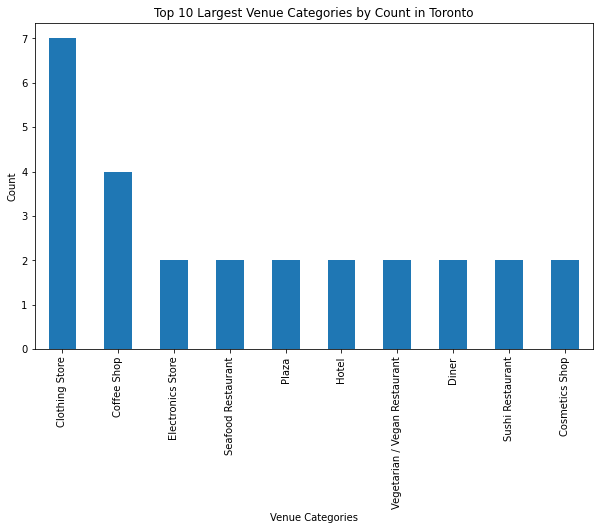

In [40]:
s2 = nearby_venues2['categories'].value_counts().head(10).nlargest(10)

# step 2: plot data
s2.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue Categories') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Top 10 Largest Venue Categories by Count in Toronto') # add title to the plot

plt.show()

### Create a map of Toronto with venues superimposed on top

In [41]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude2, longitude2], zoom_start=14)

# add markers to map
for nm, catg, lat, lng in zip(nearby_venues2['name'], nearby_venues2['categories'], nearby_venues2['lat'], nearby_venues2['lng']):
    label = '{}, {}'.format(nm, catg)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 4. Analyze TOR zip codes

In [42]:
# one hot encoding
tor_onehot = pd.get_dummies(nearby_venues2[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['postalCode'] = nearby_venues2['postalCode'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()
#tor_onehot

,postalCode,American Restaurant,Art Museum,Bakery,Bank,Bar,Bookstore,Breakfast Spot,Bubble Tea Shop,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Furniture / Home Store,Gastropub,Gym / Fitness Center,Hotel,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Movie Theater,Music Venue,New American Restaurant,Noodle House,Office,Pizza Place,Plaza,Poke Place,Restaurant,Salad Place,Seafood Restaurant,Shopping Mall,Smoothie Shop,Spa,Steakhouse,Sushi Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant
1,M5H,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M5G,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M5G,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M5B,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,M5B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [43]:
tor_onehot.shape

(78, 57)

In [44]:
tor_grouped = tor_onehot.groupby('postalCode').mean().reset_index()
#tor_grouped

In [45]:
#tor_grouped
tor_grouped.shape

(7, 57)

In [46]:
num_top_venues = 5

for hood in tor_grouped['postalCode']:
    print("----"+hood+"----")
    temp2 = tor_grouped[tor_grouped['postalCode'] == hood].T.reset_index()
    temp2.columns = ['venue','freq']
    temp2 = temp2.iloc[1:]
    temp2['freq'] = temp2['freq'].astype(float)
    temp2 = temp2.round({'freq': 2})
    print(temp2.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M5B----
               venue  freq
0     Clothing Store  0.19
1            Theater  0.06
2  Electronics Store  0.06
3              Diner  0.06
4        Coffee Shop  0.06


----M5C----
                        venue  freq
0   Latin American Restaurant  0.33
1               Smoothie Shop  0.33
2            Department Store  0.33
3                  Restaurant  0.00
4  Modern European Restaurant  0.00


----M5G----
                 venue  freq
0   Seafood Restaurant  0.06
1  Japanese Restaurant  0.06
2         Dessert Shop  0.06
3            Gastropub  0.06
4                Hotel  0.06


----M5H----
                     venue  freq
0             Concert Hall  0.06
1               Steakhouse  0.06
2  New American Restaurant  0.06
3             Noodle House  0.06
4                    Hotel  0.06


----M5T----
                        venue  freq
0                        Café   1.0
1         American Restaurant   0.0
2                 Salad Place   0.0
3  Modern European Restaurant   0.0
4 

Function to sort the venues in descending order.

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each zip code.

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postal_code_venues_sorted2 = pd.DataFrame(columns=columns)
postal_code_venues_sorted2['postalCode'] = tor_grouped['postalCode']

for ind in np.arange(tor_grouped.shape[0]):
    postal_code_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

postal_code_venues_sorted2

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5B,Clothing Store,Theater,Diner,Cosmetics Shop,Coffee Shop,Electronics Store,Vietnamese Restaurant,Plaza,Furniture / Home Store,Video Game Store
1,M5C,Latin American Restaurant,Smoothie Shop,Department Store,Vietnamese Restaurant,Colombian Restaurant,Gym / Fitness Center,Gastropub,Furniture / Home Store,Fast Food Restaurant,Electronics Store
2,M5G,Japanese Restaurant,Breakfast Spot,Hotel,Italian Restaurant,Dessert Shop,Modern European Restaurant,New American Restaurant,Coffee Shop,Poke Place,Bubble Tea Shop
3,M5H,Plaza,Breakfast Spot,New American Restaurant,Noodle House,Office,Colombian Restaurant,Concert Hall,Restaurant,Seafood Restaurant,Monument / Landmark
4,M5T,Café,Vietnamese Restaurant,Comic Shop,Hotel,Gym / Fitness Center,Gastropub,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Diner
5,M5V,Coffee Shop,Vegetarian / Vegan Restaurant,Colombian Restaurant,Gym / Fitness Center,Gastropub,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Diner,Dessert Shop
6,M5X,American Restaurant,Gym / Fitness Center,Salad Place,Colombian Restaurant,Gastropub,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Diner,Dessert Shop


### Cluster Venues

Run _k_-means to cluster the zip codes into  clusters.

In [49]:
# set number of clusters
kclusters = 7

tor_grouped_clustering = tor_grouped.drop('postalCode', 1)

#tor_grouped_clustering.head()

#nearby_venues2.sort_values(by=['categories'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nearby_venues2)


# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 3, 6, 1, 0, 2, 4], dtype=int32)

In [50]:
#del postal_code_venues_sorted2

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each zip code.

In [51]:
# add clustering labels
postal_code_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = nearby_venues2

# merge tormanhattan_grouped with tor_data to add latitude/longitude for each zip cod
tor_merged = tor_merged.join(postal_code_venues_sorted2.set_index('postalCode'), on='postalCode')

tor_merged.head() # check the last columns!
#tor_merged # check the last columns!

,name,categories,lat,lng,postalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Nathan Phillips Square,Plaza,43.652270,-79.383516,M5H,1,Plaza,Breakfast Spot,New American Restaurant,Noodle House,Office,Colombian Restaurant,Concert Hall,Restaurant,Seafood Restaurant,Monument / Landmark
2,Eggspectation Bell Trinity Square,Breakfast Spot,43.653144,-79.381980,M5G,6,Japanese Restaurant,Breakfast Spot,Hotel,Italian Restaurant,Dessert Shop,Modern European Restaurant,New American Restaurant,Coffee Shop,Poke Place,Bubble Tea Shop
3,Poke Guys,Poke Place,43.654895,-79.385052,M5G,6,Japanese Restaurant,Breakfast Spot,Hotel,Italian Restaurant,Dessert Shop,Modern European Restaurant,New American Restaurant,Coffee Shop,Poke Place,Bubble Tea Shop
4,Indigo,Bookstore,43.653515,-79.380696,M5B,5,Clothing Store,Theater,Diner,Cosmetics Shop,Coffee Shop,Electronics Store,Vietnamese Restaurant,Plaza,Furniture / Home Store,Video Game Store
5,CF Toronto Eaton Centre,Shopping Mall,43.654447,-79.380952,M5B,5,Clothing Store,Theater,Diner,Cosmetics Shop,Coffee Shop,Electronics Store,Vietnamese Restaurant,Plaza,Furniture / Home Store,Video Game Store


In [52]:
# create map
map_clusters2 = folium.Map(location=[latitude2, longitude2], zoom_start=14)
i=0
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['lat'], tor_merged['lng'], tor_merged['postalCode'], tor_merged['Cluster Labels']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = folium.Popup('Cluster ' + str(cluster) + ': ' + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

### Examine Clusters by Most Common venue

#### Cluster 1

In [53]:
y1=tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
y1.drop(columns=['categories'], inplace = True)
y1['1st Most Common Venue'].value_counts().idxmax()
#y1['1st Most Common Venue'].value_counts()

'Café'

#### Cluster 2

In [54]:
y2=tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
y2.drop(columns=['categories'], inplace = True)
y2['1st Most Common Venue'].value_counts().idxmax()
#y2['1st Most Common Venue'].value_counts()

'Plaza'

#### Cluster 3

In [55]:
y3=tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
y3.drop(columns=['categories'], inplace = True)
y3['1st Most Common Venue'].value_counts().idxmax()
#y3['1st Most Common Venue'].value_counts()

'Coffee Shop'

#### Cluster 4

In [56]:
y4=tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
y4.drop(columns=['categories'], inplace = True)
y4['1st Most Common Venue'].value_counts().idxmax()
#y4['1st Most Common Venue'].value_counts()

'Latin American Restaurant'

In [57]:
y5=tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
y5.drop(columns=['categories'], inplace = True)
y5['1st Most Common Venue'].value_counts().idxmax()
#y5['1st Most Common Venue'].value_counts()

'American Restaurant'

In [58]:
y6=tor_merged.loc[tor_merged['Cluster Labels'] == 5, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
y6.drop(columns=['categories'], inplace = True)
y6['1st Most Common Venue'].value_counts().idxmax()
#y6['1st Most Common Venue'].value_counts()

'Clothing Store'

In [59]:
y7=tor_merged.loc[tor_merged['Cluster Labels'] == 6, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
y7.drop(columns=['categories'], inplace = True)
y7['1st Most Common Venue'].value_counts().idxmax()
#y7['1st Most Common Venue'].value_counts()

'Japanese Restaurant'

In [60]:
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['lat'], tor_merged['lng'], tor_merged['postalCode'], tor_merged['Cluster Labels']):
    xtemp=tor_merged.loc[tor_merged['Cluster Labels'] == cluster, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
    new_cluster=xtemp['1st Most Common Venue'].value_counts().idxmax()
    label = folium.Popup('Cluster ' + str(cluster) + ': ' + str(new_cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

# ================ End of TOR analysis =====================

## ============== New York City's Most Common Venue Groups ================

In [61]:
df_x1=pd.DataFrame(x1.value_counts().head(10).nlargest(5))
#df_x1=pd.DataFrame(x1)
#df_x1

In [62]:
df_x2=pd.DataFrame(x2.value_counts().head(10).nlargest(5))
#df_x2=pd.DataFrame(x2)
#df_x2

In [63]:
df_x3=pd.DataFrame(x3.value_counts().head(10).nlargest(5))
#df_x3=pd.DataFrame(x3)
#df_x3

In [64]:
df_x4=pd.DataFrame(x4.value_counts().head(10).nlargest(5))
#df_x4=pd.DataFrame(x4)
#df_x4

In [66]:
#df_x5=pd.DataFrame(x5.value_counts().head(10).nlargest(5))
#df_x5=pd.DataFrame(x5)
#df_x5

In [67]:
#df_x6=pd.DataFrame(x6.value_counts().head(10).nlargest(5))
#df_x6=pd.DataFrame(x6)
#df_x6

In [68]:
#df_x7=pd.DataFrame(x7.value_counts().head(10).nlargest(5))
#df_x7=pd.DataFrame(x7)
#df_x7

## ============== Toronto's Most Common Venue Groups ================

In [69]:
df_y1=pd.DataFrame(y1.value_counts().head(10).nlargest(5))
#df_y1=pd.DataFrame(y1)
#df_y1

In [70]:
df_y2=pd.DataFrame(y2.value_counts().head(10).nlargest(5))
#df_y2=pd.DataFrame(y2)
#df_y2

In [72]:
df_y3=pd.DataFrame(y3.value_counts().head(10).nlargest(5))
#df_y3=pd.DataFrame(y3)
#df_y3

In [73]:
df_y4=pd.DataFrame(y4.value_counts().head(10).nlargest(5))
#df_y4=pd.DataFrame(y4)
#df_y4

In [74]:
df_y5=pd.DataFrame(y5.value_counts().head(10).nlargest(5))
#df_y5=pd.DataFrame(y5)
#df_y5

In [75]:
df_y6=pd.DataFrame(y6.value_counts().head(10).nlargest(5))
#df_y6=pd.DataFrame(y6)
#df_y6

In [76]:
df_y7=pd.DataFrame(y7.value_counts().head(10).nlargest(5))
#df_y7=pd.DataFrame(y7)
#df_y7

# Comparison of Y (Destination) to X (Source)

In [77]:
#frames_x = [df_x1, df_x2, df_x3, df_x4, df_x5, df_x6, df_x7]
frames_x = [df_x1, df_x2, df_x3, df_x4]
result_x = pd.concat(frames_x)
#source_x=result_x.value_counts().head(10).nlargest(10)
#source_x
result_x
#result_x['1st Most Common Venue'].value_counts()

,,,,,,,,,,,0
Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,
0,Indian Restaurant,Coffee Shop,Wine Shop,Hotel Bar,Hotel,Women's Store,Gym,Furniture / Home Store,French Restaurant,Falafel Restaurant,42
1,Plaza,Building,Yoga Studio,Discount Store,Comic Shop,Coworking Space,Cuban Restaurant,Dance Studio,Donut Shop,Cocktail Bar,2
2,Sushi Restaurant,Spa,Gym / Fitness Center,Restaurant,Asian Restaurant,Bakery,Cocktail Bar,Falafel Restaurant,Medical Center,Molecular Gastronomy Restaurant,15
3,Hotel,Coffee Shop,Italian Restaurant,Burger Joint,Pizza Place,Sandwich Place,Yoga Studio,Fast Food Restaurant,Hotel Bar,Gym,41


In [78]:
frames_y= [df_y1, df_y2, df_y3, df_y4, df_y5, df_y6, df_y7]
#frames_y = [df_y1, df_y2, df_y3, df_y4]
result_y = pd.concat(frames_y)
result_y
#result_y['1st Most Common Venue'].value_counts()

,,,,,,,,,,,0
Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,
0,Café,Vietnamese Restaurant,Comic Shop,Hotel,Gym / Fitness Center,Gastropub,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Diner,1
1,Plaza,Breakfast Spot,New American Restaurant,Noodle House,Office,Colombian Restaurant,Concert Hall,Restaurant,Seafood Restaurant,Monument / Landmark,16
2,Coffee Shop,Vegetarian / Vegan Restaurant,Colombian Restaurant,Gym / Fitness Center,Gastropub,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Diner,Dessert Shop,2
3,Latin American Restaurant,Smoothie Shop,Department Store,Vietnamese Restaurant,Colombian Restaurant,Gym / Fitness Center,Gastropub,Furniture / Home Store,Fast Food Restaurant,Electronics Store,3
4,American Restaurant,Gym / Fitness Center,Salad Place,Colombian Restaurant,Gastropub,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Diner,Dessert Shop,3
5,Clothing Store,Theater,Diner,Cosmetics Shop,Coffee Shop,Electronics Store,Vietnamese Restaurant,Plaza,Furniture / Home Store,Video Game Store,36
6,Japanese Restaurant,Breakfast Spot,Hotel,Italian Restaurant,Dessert Shop,Modern European Restaurant,New American Restaurant,Coffee Shop,Poke Place,Bubble Tea Shop,17
